In [ ]:
import sys
print(sys.executable)


c:\Users\gabri\AppData\Local\Programs\Python\Python311\python.exe


In [2]:
import pandas as pd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from xgboost import XGBRegressor, plot_importance

import numpy as np
import matplotlib.pyplot as plt

# **1- Importação do Dataframe de Manaus**

In [ ]:
df = pd.read_csv('../data/pre-processado/por-municipio/completo/dados-manaus-preprocessado.csv')

In [ ]:
print(f"INICIO: {len(df)} linhas")

INICIO: 12022 linhas


# **2- Pré-processamento**

* **2.1 - Limitação do dataframe para acima do ano 2000**

In [ ]:
df['ano'] = df['ano'].astype(int)
df = df[df['ano'] >= 2000]

* **2.2- Remoção de outliers**

In [ ]:
print(f"Existem {len(df)} linhas antes de remover outliers.")

colunas_numericas = df.select_dtypes(include='number').columns

for col in colunas_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df = df[(df[col] >= limite_inferior) & (df[col] <= limite_superior)]

print(f"Existem {len(df)} linhas depois de remover outliers.")

Existem 8735 linhas antes de remover outliers.
Existem 6722 linhas depois de remover outliers.


* **2.3- Normalização dos Dados**

* **2.4 - Criação de variáveis derivadas**

In [ ]:
df["chuva_3d"] = df["chuva_final"].rolling(window=3).sum()
df["chuva_5d"] = df["chuva_final"].rolling(window=5).sum()
df["chuva_7d"] = df["chuva_final"].rolling(window=7).sum()

# **3 - Modelo**

* **3.1 - Encontrando parâmetros**

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.85, 1.0],
    'colsample_bytree': [0.7, 0.85, 1.0],
    'gamma': [0, 0.15, 0.3]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

print("⚡ XGBoost - Melhores hiperparâmetros:")
print(grid_search_xgb.best_params_)

* **3.2 - Treino**

In [ ]:
X = df.drop(columns=['vazao', 'municipio', 'uf'])
y = df['vazao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

best_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

* **3.3 - Predição e Avaliação**

In [ ]:
y_pred = best_xgb.predict(X_test)

xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_test, y_pred)

importances = best_xgb.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# **4- Exibição dos Resultados**

* **4.1 - Métricas de Desempenho**

🔷 XGBoost
RMSE: 23038.34
MAE: 17359.91
R²: 0.7286 (sem remoção de outliers: 0.778)


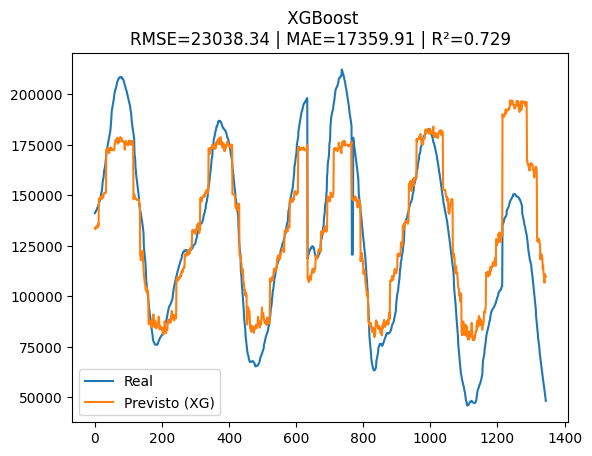

In [ ]:
print("🔷 XGBoost")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE: {xgb_mae:.2f}")
print(f"R²: {xgb_r2:.4f} (sem remoção de outliers: 0.778)")

plt.plot(y_test.values, label='Real')
plt.plot(y_pred, label='Previsto (XG)')
plt.legend()
plt.title(f" XGBoost\nRMSE={xgb_rmse:.2f} | MAE={xgb_mae:.2f} | R²={xgb_r2:.3f}")
plt.show()

* **4.2 - Gráfico de Dispersão**

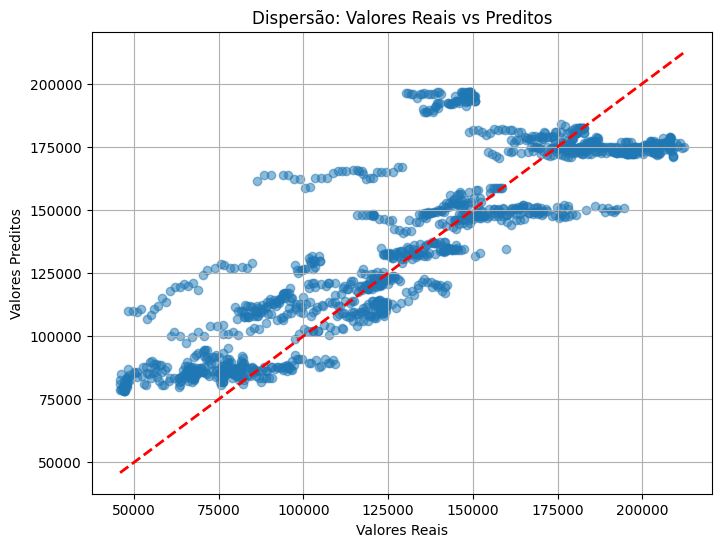

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Dispersão: Valores Reais vs Preditos')
plt.grid(True)
plt.show()

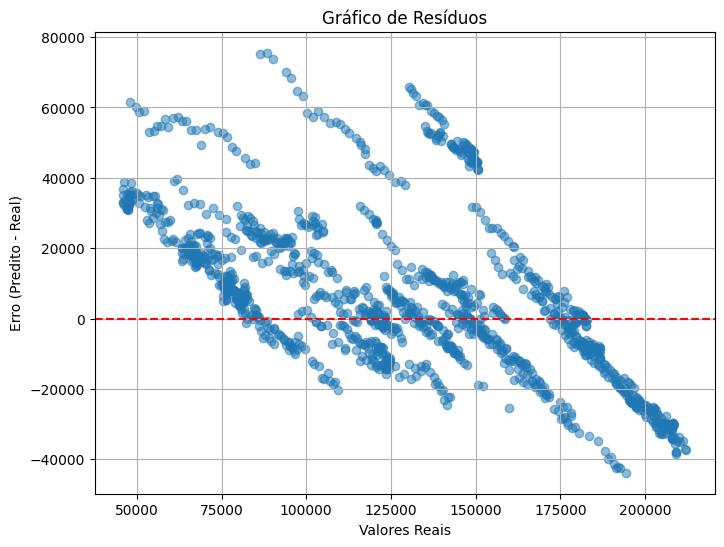

In [ ]:
import matplotlib.pyplot as plt

residuos = y_pred - y_test
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Erro (Predito - Real)')
plt.title('Gráfico de Resíduos')
plt.grid(True)
plt.show()


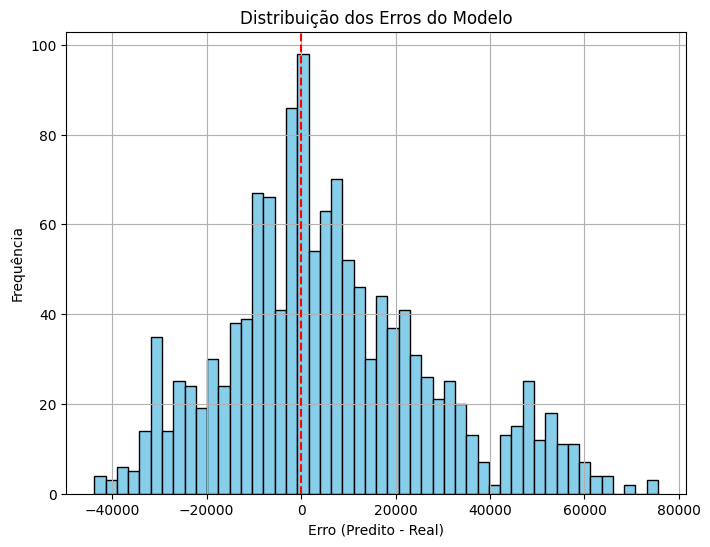

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(residuos, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Erro (Predito - Real)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros do Modelo')
plt.grid(True)
plt.show()


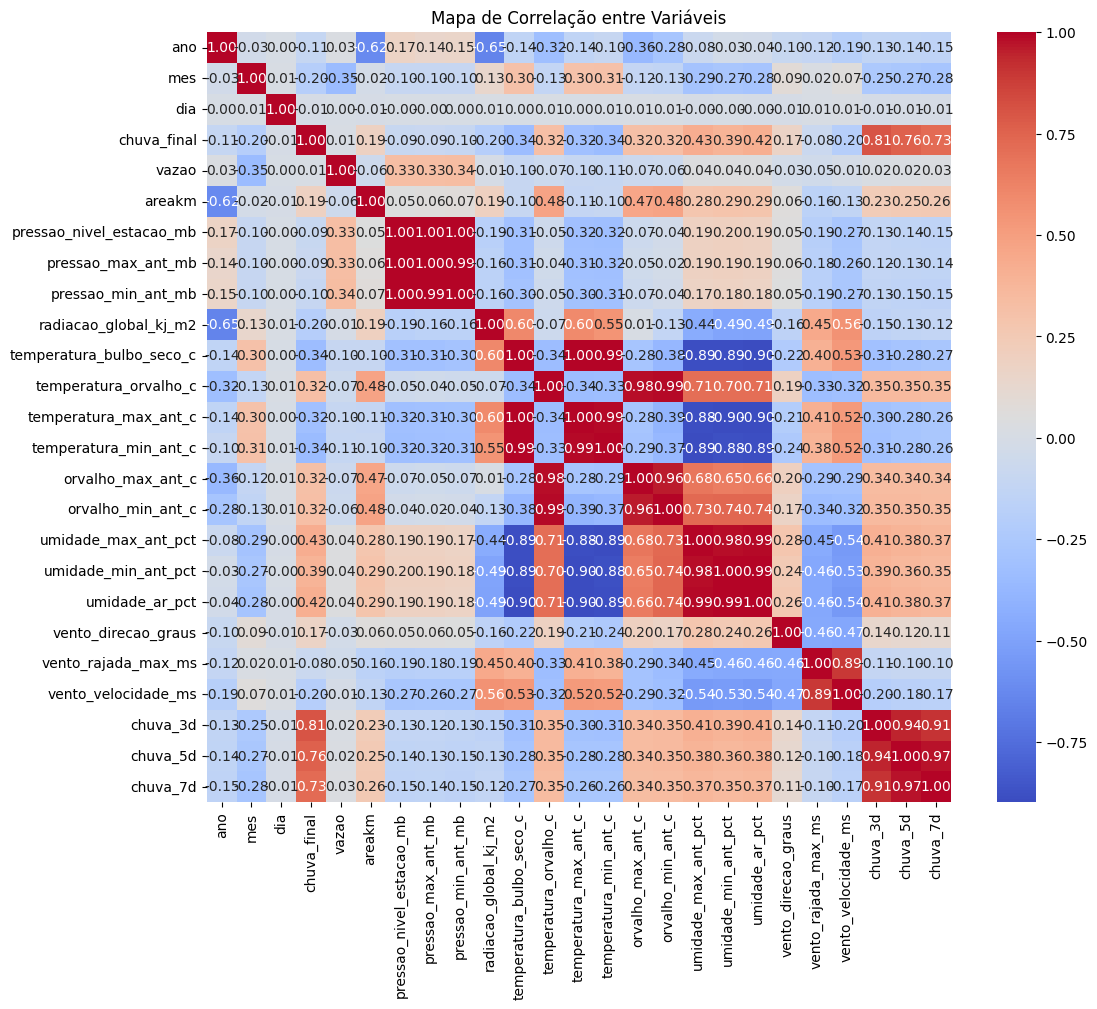

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove colunas não numéricas (como 'municipio') criando uma nova versão apenas com numéricas
df_numerico = df.select_dtypes(include='number')

# Plotando o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_numerico.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Mapa de Correlação entre Variáveis')
plt.show()



* **4.3 - Feature Importance**

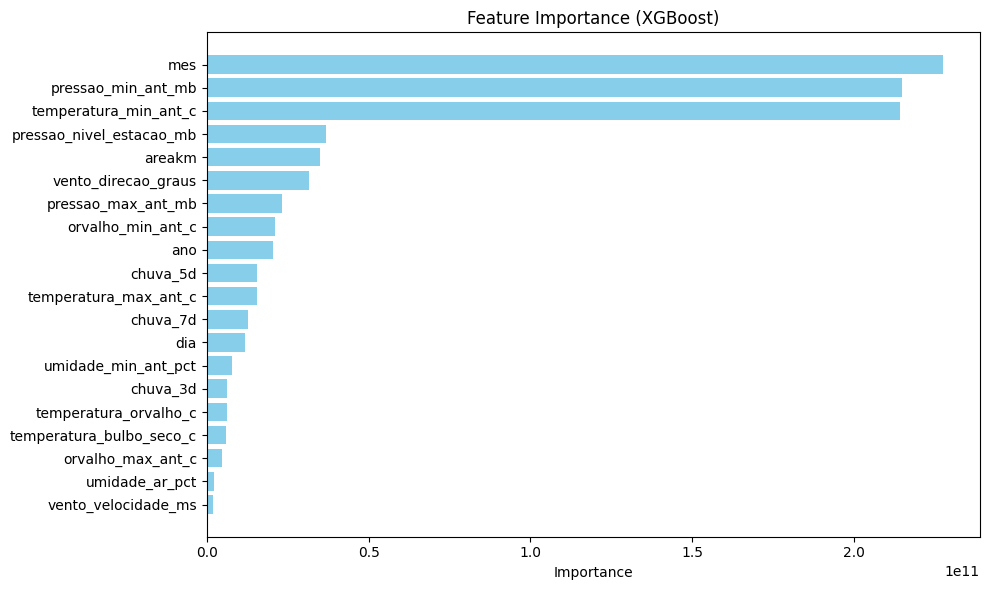

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Para mostrar a mais importante no topo
plt.tight_layout()
plt.show()

PRINT FINAL

In [ ]:
# POR FAVOR - DEIXAR ESSE BLOCO COMO O ULTIMO BLOCO DO CÓDIGO
print(f"FIM: {len(df)} linhas")

FIM: 6722 linhas
